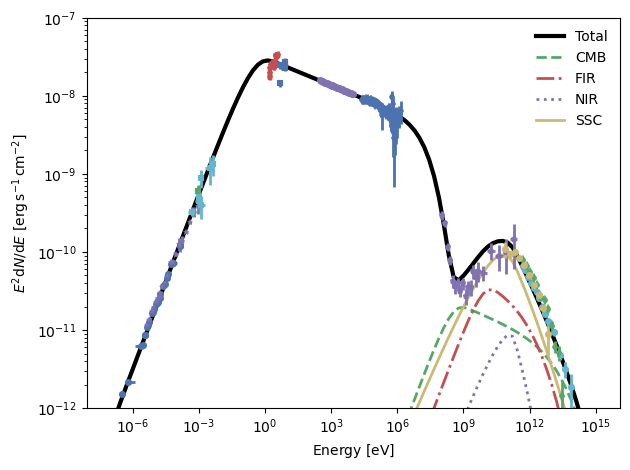

In [2]:
import astropy.units as u
import numpy as np
from astropy.constants import c
from astropy.io import ascii

import naima
from naima.models import (
    ExponentialCutoffBrokenPowerLaw,
    InverseCompton,
    Synchrotron,
)

ECBPL = ExponentialCutoffBrokenPowerLaw(
    amplitude=3.699e36 / u.eV,
    e_0=1 * u.TeV,
    e_break=0.265 * u.TeV,
    alpha_1=1.5,
    alpha_2=3.233,
    e_cutoff=1863 * u.TeV,
    beta=2.0,
)

eopts = {"Eemax": 50 * u.PeV, "Eemin": 0.1 * u.GeV}

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

IC = InverseCompton(
    ECBPL,
    seed_photon_fields=[
        "CMB",
        ["FIR", 70 * u.K, 0.5 * u.eV / u.cm ** 3],
        ["NIR", 5000 * u.K, 1 * u.eV / u.cm ** 3],
        ["SSC", Esy, phn_sy],
    ],
    Eemax=50 * u.PeV,
    Eemin=0.1 * u.GeV,
)

# Use plot_data from naima to plot the observed spectra
data = ascii.read("CrabNebula_spectrum.ecsv")
figure = naima.plot_data(data, e_unit=u.eV)
ax = figure.axes[0]

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(
    energy,
    IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc),
    lw=3,
    c="k",
    label="Total",
)
for i, seed, ls in zip(
    range(4), ["CMB", "FIR", "NIR", "SSC"], ["--", "-.", ":", "-"]
):
    ax.loglog(
        energy,
        IC.sed(energy, 2 * u.kpc, seed=seed),
        lw=2,
        c=naima.plot.color_cycle[i + 1],
        label=seed,
        ls=ls,
    )


ax.set_ylim(1e-12, 1e-7)
ax.legend(loc="upper right", frameon=False)
figure.tight_layout()
figure.savefig("CrabNebula_SynSSC.png")


In [3]:
data

energy,flux,flux_error_lo,flux_error_hi,flux_error,component,paper,group
MeV,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),,,
float64,float64,float64,float64,float64,str6,str14,int64
3.37058758179e-13,1.5322e-12,4.443e-14,4.443e-14,4.443e-14,nebula,baars,0
6.28616268615e-13,2.1736e-12,6.303e-14,6.303e-14,6.303e-14,nebula,baars,0
2.32426486064e-12,6.2382e-12,1.8715e-13,1.8715e-13,1.8715e-13,nebula,baars,0
2.92803063567e-12,6.4428e-12,1.6107e-13,1.6107e-13,1.6107e-13,nebula,baars,0
3.55668674483e-12,8.7376e-12,2.1844e-13,2.1844e-13,2.1844e-13,nebula,baars,0
3.62281048829e-12,8.76e-12,2.19e-13,2.19e-13,2.19e-13,nebula,baars,0
...,...,...,...,...,...,...,...
14799451.384,6.1415e-12,1.088e-12,1.0879e-12,1.08795e-12,nebula,hess,7
